# Predicting ROI of Personalised Marketing Efforts

## Table of Contents

1. Problem Statement
2. Data Source
3. Data Preprocessing
4. EDA
5. Modelling
6. Modelling with Improved Relational Data

## Import Datasets
Dataset 1: https://www.kaggle.com/datasets/sinderpreet/analyze-the-marketing-spending
<br>Dataset 2: https://www.kaggle.com/datasets/naniruddhan/online-advertising-digital-marketing-data

In [1]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('Marketing.csv')
df2 = pd.read_csv('archive/online_advertising_performance_data.csv')

### Data Cleaning for Dataset 1

In [2]:
# Check for missing values and data types
print(df1.info())

# Drop duplicates
df1.drop_duplicates(inplace=True)

# Check for missing values
print(df1.isnull().sum())

# Drop missing values (if any)
df1 = df1.dropna()

# Calculate Click to Revenue Conversion Rate
df1['click_to_revenue_ratio'] = df1['revenue'] / df1['clicks']

df1_cleaned = df1.drop(columns=["id", "c_date", "campaign_name", "campaign_id"])
df1_cleaned = df1_cleaned.rename(columns={"mark_spent": "cost"})

# Verify cleaned data
print(df1_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             308 non-null    int64  
 1   c_date         308 non-null    object 
 2   campaign_name  308 non-null    object 
 3   category       308 non-null    object 
 4   campaign_id    308 non-null    int64  
 5   impressions    308 non-null    int64  
 6   mark_spent     308 non-null    float64
 7   clicks         308 non-null    int64  
 8   leads          308 non-null    int64  
 9   orders         308 non-null    int64  
 10  revenue        308 non-null    float64
dtypes: float64(2), int64(6), object(3)
memory usage: 26.6+ KB
None
id               0
c_date           0
campaign_name    0
category         0
campaign_id      0
impressions      0
mark_spent       0
clicks           0
leads            0
orders           0
revenue          0
dtype: int64
     category  impressions      c

## Data Cleaning for Dataset 2

In [3]:
# Check for missing values
print(df2.isnull().sum())

# Drop columns where all values are NaN
df2_cleaned = df2.dropna(axis=1, how='all')

# Verify the updated dataframe
print(df2_cleaned.columns)

# Define a base conversion rate (you can adjust this based on your understanding)
base_conversion_rate = 0.025  # 2.5% of clicks turn into leads

# Add random noise to simulate variance in campaign performance
conversion_adjustment = np.random.uniform(0.9, 1.1, len(df2))  # Random adjustment between 90% to 110%

# Create a synthetic 'leads' column based on clicks, budget, and random noise
df2_cleaned['leads'] = (df2_cleaned['clicks'] * base_conversion_rate * conversion_adjustment).astype(int)

# Remove the specified columns
df2_cleaned = df2_cleaned.drop(columns=["month", "day", "campaign_number", "user_engagement","banner"])

# Rename the 'placement' column to 'category'
df2_cleaned = df2_cleaned.rename(columns={"placement": "category"})
# Rename 'displays' to 'impressions'
df2_cleaned = df2_cleaned.rename(columns={"displays": "impressions"})
# Replace 'abc' with 'jkl' in the 'category' column
df2_cleaned['category'] = df2_cleaned['category'].replace('abc', 'jkl')
# Rename 'post_click_conversions' to 'orders'
df2_cleaned = df2_cleaned.rename(columns={"post_click_conversions": "orders"})

# Remove the 'revenue' column
df2_cleaned = df2_cleaned.drop(columns=["revenue"])

# Rename 'post_click_sales_amount' to 'revenue'
df2_cleaned = df2_cleaned.rename(columns={"post_click_sales_amount": "revenue"})
# Add a 'click_to_revenue_ratio' column, handling division by zero
df2_cleaned['click_to_revenue_ratio'] = df2_cleaned.apply(lambda row: row['revenue'] / row['clicks'] if row['clicks'] != 0 else 0, axis=1)

# Verify the new column
print(df2_cleaned[['revenue', 'clicks', 'click_to_revenue_ratio']].head())
# Replace category elements with new values
df2_cleaned['category'] = df2_cleaned['category'].replace({
    'mno': 'social',
    'def': 'search',
    'ghi': 'influencer',
    'jkl': 'media'
})

# Verify the changes
print(df2_cleaned['category'].value_counts())
print(df2_cleaned.head())

month                          0
day                            0
campaign_number                0
user_engagement                0
banner                         0
placement                    413
displays                       0
cost                           0
clicks                         0
revenue                        0
post_click_conversions         0
post_click_sales_amount        0
Unnamed: 12                15408
Unnamed: 13                15408
dtype: int64
Index(['month', 'day', 'campaign_number', 'user_engagement', 'banner',
       'placement', 'displays', 'cost', 'clicks', 'revenue',
       'post_click_conversions', 'post_click_sales_amount'],
      dtype='object')
      revenue  clicks  click_to_revenue_ratio
0      0.0000       0                0.000000
1   1972.4602     158               12.483925
2   2497.2636     158               15.805466
3  24625.3234    1796               13.711205
4      0.0000       1                0.000000
category
social        4501
search

/var/folders/pg/k1hh45tx53v5c4hp65ntyjtc0000gn/T/ipykernel_60544/1211675648.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_cleaned['leads'] = (df2_cleaned['clicks'] * base_conversion_rate * conversion_adjustment).astype(int)


## Join Dataset 1 & Dataset 2

In [4]:
common_columns = ["category", "impressions", "cost", "clicks", "leads", "orders", "revenue", "click_to_revenue_ratio"]

# Concatenate the two dataframes based on these common columns
df_combined = pd.concat([df1_cleaned[common_columns], df2_cleaned[common_columns]], axis=0, ignore_index=True)

# Verify the combined dataframe
print(df_combined.head())

     category  impressions      cost  clicks  leads  orders  revenue  \
0      social       148263   7307.37    1210     13       1   4981.0   
1      social       220688  16300.20    1640     48       3  14962.0   
2      search        22850   5221.60     457      9       1   7981.0   
3      search       147038   6037.00    1196     24       1   2114.0   
4  influencer       225800  29962.20    2258     49      10  84490.0   

   click_to_revenue_ratio  
0                4.116529  
1                9.123171  
2               17.463895  
3                1.767559  
4               37.418069  


## EDA

### Campaign Spending vs Revenue

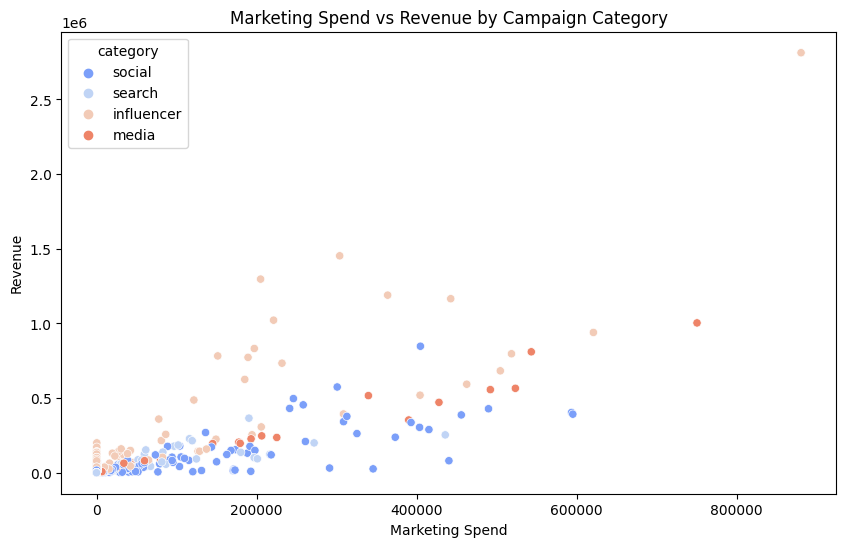

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Marketing Spend vs Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cost', y='revenue', data=df_combined, hue='category', palette='coolwarm')
plt.title('Marketing Spend vs Revenue by Campaign Category')
plt.xlabel('Marketing Spend')
plt.ylabel('Revenue')
plt.show()

### Campaign Performance: Clicks, Leads, Orders

/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

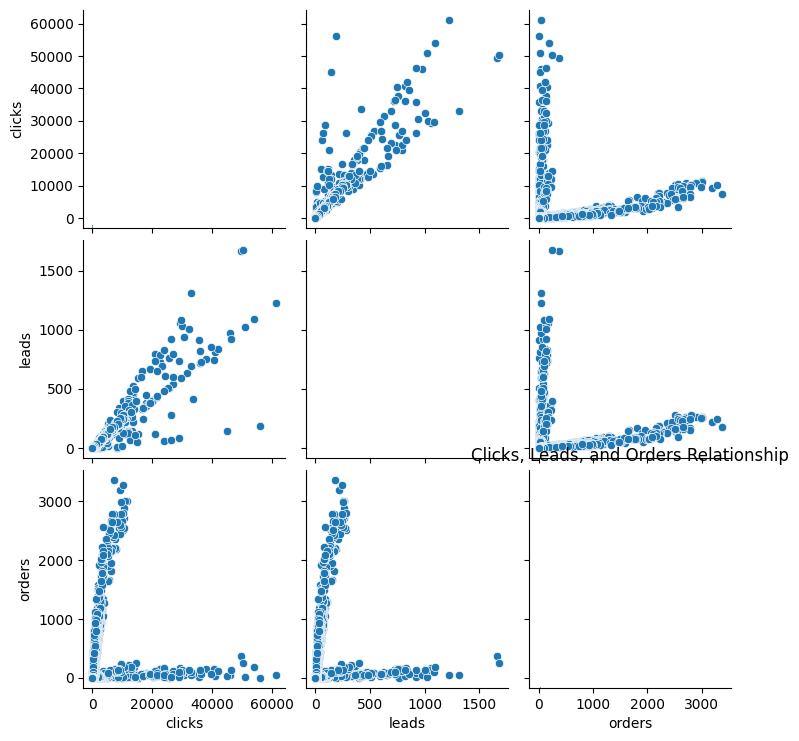

In [6]:
metrics = ['clicks', 'leads', 'orders']

plt.figure(figsize=(10, 6))
sns.pairplot(df_combined[metrics])
plt.title('Clicks, Leads, and Orders Relationship')
plt.show()

### Revenue by Category

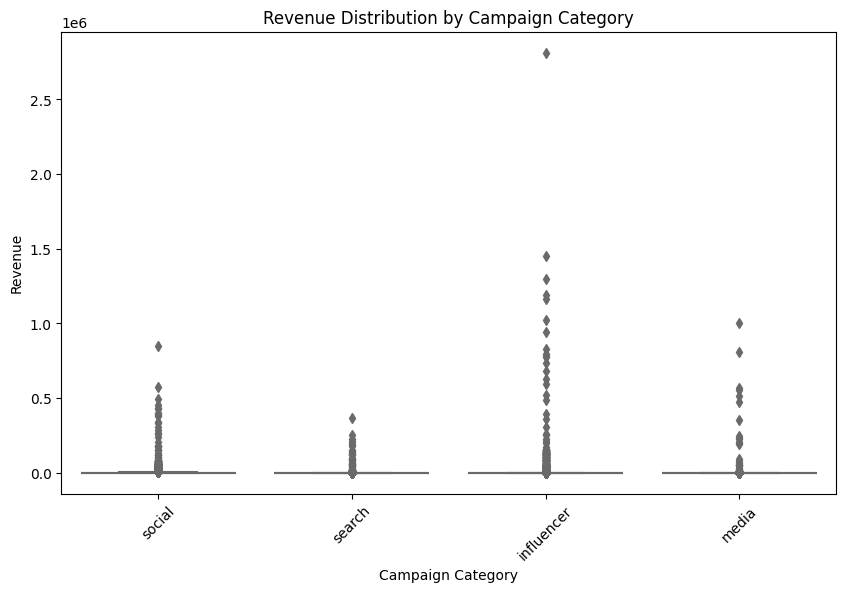

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='category', y='revenue', palette='Set3')
plt.title('Revenue Distribution by Campaign Category')
plt.xlabel('Campaign Category')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

### Marketing Spend Distribution

/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


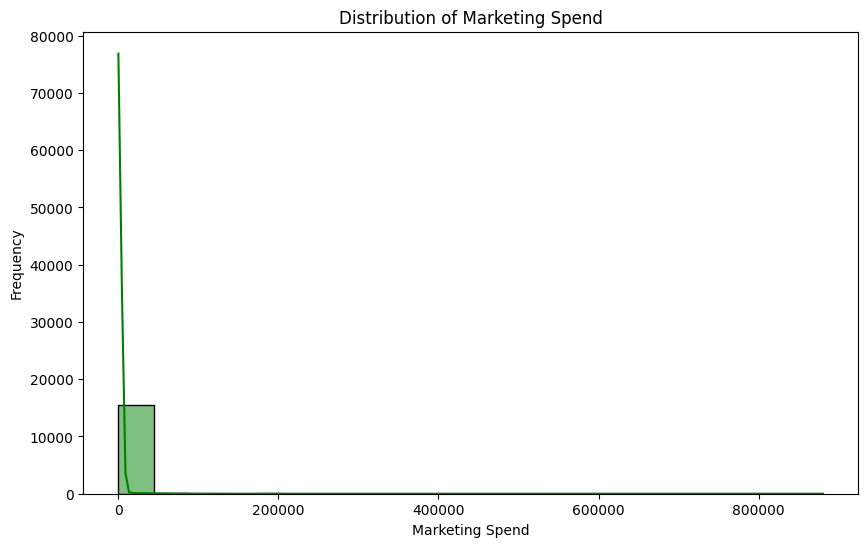

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['cost'], bins=20, kde=True, color='green')
plt.title('Distribution of Marketing Spend')
plt.xlabel('Marketing Spend')
plt.ylabel('Frequency')
plt.show()

### Click to Revenue Conversion Rate

/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


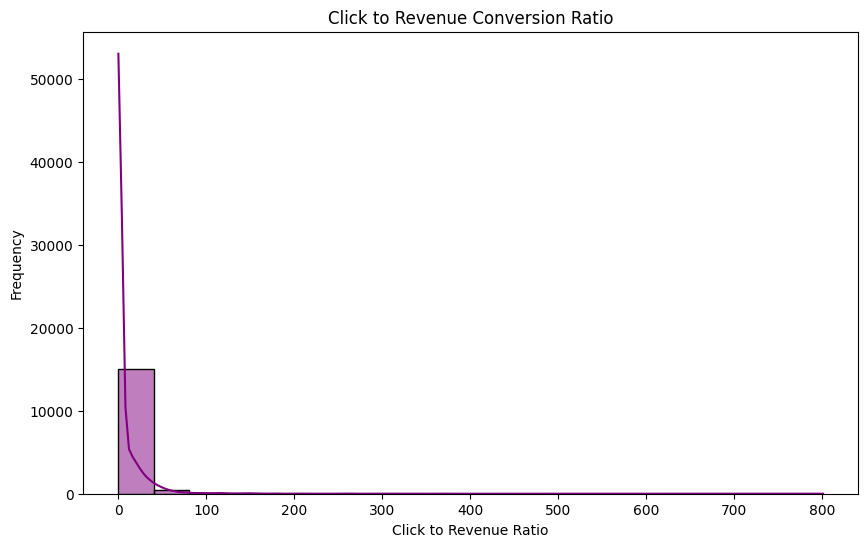

In [9]:
# Plot Click to Revenue Ratio
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['click_to_revenue_ratio'].dropna(), bins=20, kde=True, color='purple')
plt.title('Click to Revenue Conversion Ratio')
plt.xlabel('Click to Revenue Ratio')
plt.ylabel('Frequency')
plt.show()

### Revenue vs Leads

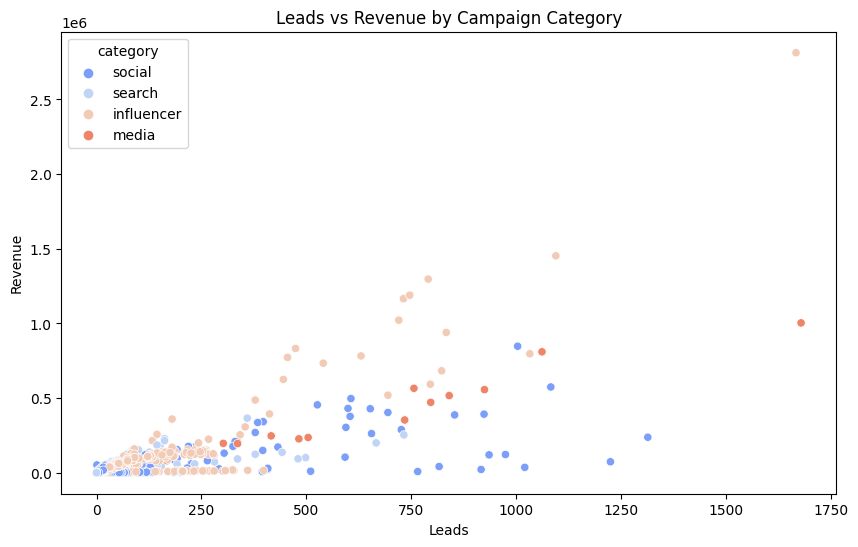

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='leads', y='revenue', data=df_combined, hue='category', palette='coolwarm')
plt.title('Leads vs Revenue by Campaign Category')
plt.xlabel('Leads')
plt.ylabel('Revenue')
plt.show()

# Random Forest Regressor

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Assume df is your already available dataset
# Selecting features (category and cost) and targets (clicks, leads, orders)
X = df_combined[['category', 'cost']]  # Input features: category (categorical) and cost (numerical)
y = df_combined[['clicks', 'leads', 'orders']]  # Targets: clicks, leads, orders (all numerical)

# One-hot encoding for 'category'
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X[['category']])

# Concatenate the encoded category with cost
X_transformed = np.concatenate([X_encoded, X[['cost']].values], axis=1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Define and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error and R^2 score for each target
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print the accuracy for each target variable
target_names = ['clicks', 'leads', 'orders']
for i, target in enumerate(target_names):
    print(f"{target} - MSE: {mse[i]}, R^2: {r2[i]}")

# ===========================
# Generating a Synthetic Dataset for Testing
# ===========================

# Categories for the synthetic data
categories = ['influencer', 'social', 'search', 'media']
n_samples = 100  # Number of synthetic data points

# Generating random synthetic data
synthetic_data = pd.DataFrame({
    'category': np.random.choice(categories, size=n_samples),
    'cost': np.random.uniform(100, 5000, size=n_samples)  # Random cost values
})

# One-hot encode the synthetic categories
synthetic_encoded = encoder.transform(synthetic_data[['category']])

# Concatenate the encoded categories with synthetic cost
X_synthetic = np.concatenate([synthetic_encoded, synthetic_data[['cost']].values], axis=1)

# Predict the target variables on synthetic data
y_synthetic_pred = model.predict(X_synthetic)

# Display the synthetic data and corresponding predictions
synthetic_data['clicks'] = y_synthetic_pred[:, 0]
synthetic_data['leads'] = y_synthetic_pred[:, 1]
synthetic_data['orders'] = y_synthetic_pred[:, 2]

# Show synthetic dataset with predictions
print(synthetic_data)

clicks - MSE: 1055489.5951584924, R^2: 0.7522212253456497
leads - MSE: 784.3836289920907, R^2: 0.7490502010253259
orders - MSE: 9636.681216053212, R^2: 0.7865168290089931
      category         cost    clicks   leads   orders
0       search  4275.285584   6861.76   53.74     1.03
1       social  2331.577144   1156.91   21.30     0.93
2   influencer   404.456392  10557.52  263.54  2691.72
3       search  2360.580788   1187.22   25.96     0.69
4   influencer  3254.284106   1502.38   35.88   299.00
..         ...          ...       ...     ...      ...
95      social  1480.498071   1008.41    5.88     0.63
96       media  2441.807288   1431.41   31.78     0.90
97      search   238.184367   1146.77   27.58   684.09
98      social  2785.344538    414.84    9.16     0.80
99      search  1693.477620    181.71    2.26     0.05

[100 rows x 5 columns]


## 6. Model with Improved Relational Data

### 6.1 Introducing Regressor Chain

To better capture the relationship between clicks, leads, and orders, we use a Regressor Chain. This method allows us to sequentially model the dependencies between these variables:

Our method is to use the predicted clicks as an input to predict leads, and then use both clicks and leads to predict orders.

### 6.2 Advantages of Using Regressor Chain

1. Capturing Dependencies: Reflects the real-world dependency where clicks lead to leads, and leads can convert into orders.
2. Enhanced Accuracy: By including earlier predictions as inputs, the model can better predict subsequent outcomes.

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import RegressorChain

# Assume df_combined is your dataset with features and targets already defined
# Selecting features (category and cost) and targets (clicks, leads, orders)
X = df_combined[['category', 'cost']]  # Input features
y = df_combined[['clicks', 'leads', 'orders']]  # Targets

# One-hot encoding for the 'category' column
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X[['category']])

# Concatenate the encoded category with the cost column
X_transformed = np.concatenate([X_encoded, X[['cost']].values], axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Define the base model and RegressorChain for chained multi-output regression
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = RegressorChain(base_model, order=[0, 1, 2])  # Predict clicks, then leads, then orders

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error and R^2 score for each target
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print the accuracy for each target variable
target_names = ['clicks', 'leads', 'orders']
for i, target in enumerate(target_names):
    print(f"{target} - MSE: {mse[i]}, R^2: {r2[i]}")


clicks - MSE: 1050362.933327281, R^2: 0.7534247218011634
leads - MSE: 729.0530271628498, R^2: 0.7667522576376468
orders - MSE: 10956.015115316417, R^2: 0.7572893825369188


In [13]:
y.head()

,clicks,leads,orders
0,1210,13,1
1,1640,48,3
2,457,9,1
3,1196,24,1
4,2258,49,10


In [15]:
y_pred

array([[2.01100000e+01, 0.00000000e+00, 4.40000000e-01],
       [6.10761183e-02, 0.00000000e+00, 0.00000000e+00],
       [5.31510000e+02, 1.28700000e+01, 1.68500000e+01],
       ...,
       [9.66000000e+01, 2.00000000e+00, 1.50100000e+01],
       [1.19570000e+02, 2.63000000e+00, 4.82100000e+01],
       [8.17500000e+01, 1.49000000e+00, 5.65000000e+00]])